In [40]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU
)
from skimage.transform import resize

In [41]:
dirname = os.path.join(os.getcwd(), 'sportimages')
imgpath = dirname + os.sep

images = []
labels = []
deportes = []
label_map = {}
current_label = 0

print("Leyendo imágenes de", imgpath)

for root, _, filenames in os.walk(imgpath):
    # saltar la carpeta raíz que solo contiene las subcarpetas
    if root == imgpath:
        continue

    folder = os.path.basename(root)

    # asignar un número de clase a cada carpeta de deporte
    if folder not in label_map:
        label_map[folder] = current_label
        deportes.append(folder)
        current_label += 1

    for filename in filenames:
        if re.search(r"\.(jpg|jpeg|png|bmp|tiff)$", filename):
            filepath = os.path.join(root, filename)
            try:
                image = plt.imread(filepath)

                # redimensionar a 28x28 (o 64x64 si quieres mejorar)
                image_resized = resize(
                    image, (28, 28),
                    anti_aliasing=True,
                    clip=False,
                    preserve_range=True
                )

                # asegurar 3 canales
                if len(image_resized.shape) == 3 and image_resized.shape[2] == 3:
                    img_ok = image_resized
                elif len(image_resized.shape) == 2:
                    img_ok = np.stack([image_resized]*3, axis=-1)
                else:
                    continue  # formatos raros, se ignoran

                images.append(img_ok)
                labels.append(label_map[folder])

            except Exception as e:
                print(f"Error al leer {filepath}: {e}")
                continue

print("Directorios (deportes) leídos:", len(deportes))
print("Deportes:", deportes)
print("Total de imágenes:", len(images))
print("Total de etiquetas:", len(labels))

Leyendo imágenes de D:\PedroCarpetas\Tecnologico\Semestre 10\IA\Inteligencia-Artificial\sportimages\
Directorios (deportes) leídos: 10
Deportes: ['americano', 'basket', 'beisball', 'boxeo', 'ciclismo', 'f1', 'futbol', 'golf', 'natacion', 'tenis']
Total de imágenes: 77127
Total de etiquetas: 77127


In [42]:
X = np.array(images, dtype=np.float32) / 255.0
y = np.array(labels)

nClasses = len(deportes)

print("Forma de X:", X.shape)
print("Longitud de y:", y.shape)
print("Clases únicas en y:", np.unique(y))
print("Cantidad de clases:", nClasses)
print("Deportes (orden de clases):")
for i, dep in enumerate(deportes):
    print(i, dep)

Forma de X: (77127, 28, 28, 3)
Longitud de y: (77127,)
Clases únicas en y: [0 1 2 3 4 5 6 7 8 9]
Cantidad de clases: 10
Deportes (orden de clases):
0 americano
1 basket
2 beisball
3 boxeo
4 ciclismo
5 f1
6 futbol
7 golf
8 natacion
9 tenis


In [43]:
y = np.array(labels)
X = np.array(images, dtype=np.float32)  # Convertir directamente a float32

classes = np.unique(y)
nClasses = len(classes)
print('Total de clases:', nClasses)
print('Clases:', classes)

# Normalizar imágenes
X = X / 255.0

print("Forma de X:", X.shape)
print("Valores min/max de X:", X.min(), X.max())

Total de clases: 10
Clases: [0 1 2 3 4 5 6 7 8 9]
Forma de X: (77127, 28, 28, 3)
Valores min/max de X: 0.0 1.0


In [44]:
# Primera división: train/test
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42)
print('Datos de entrenamiento:', train_X.shape, train_Y.shape)
print('Datos de prueba:', test_X.shape, test_Y.shape)

# Convertir etiquetas a one-hot encoding
train_Y_one_hot = to_categorical(train_Y, nClasses)
test_Y_one_hot = to_categorical(test_Y, nClasses)

print('Etiqueta original:', train_Y[0])
print('Después de one-hot:', train_Y_one_hot[0])

# Segunda división: train/validation
train_X, valid_X, train_label, valid_label = train_test_split(
    train_X, train_Y_one_hot, test_size=0.2, random_state=13
)

print('Forma final de datos:')
print('Train:', train_X.shape, train_label.shape)
print('Valid:', valid_X.shape, valid_label.shape)
print('Test:', test_X.shape, test_Y_one_hot.shape)

Datos de entrenamiento: (61701, 28, 28, 3) (61701,)
Datos de prueba: (15426, 28, 28, 3) (15426,)
Etiqueta original: 8
Después de one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Forma final de datos:
Train: (49360, 28, 28, 3) (49360, 10)
Valid: (12341, 28, 28, 3) (12341, 10)
Test: (15426, 28, 28, 3) (15426, 10)


In [45]:
def create_model(input_shape, num_classes):
    """Crear modelo CNN mejorado"""
    model = Sequential([
        # Primera capa convolucional
        Conv2D(32, kernel_size=(3, 3), activation='linear', 
               padding='same', input_shape=input_shape),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(pool_size=(2, 2), padding='same'),
        Dropout(0.25),
        
        # Segunda capa convolucional
        Conv2D(64, kernel_size=(3, 3), activation='linear', padding='same'),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(pool_size=(2, 2), padding='same'),
        Dropout(0.25),
        
        # Capas densas
        Flatten(),
        Dense(128, activation='linear'),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Crear el modelo
input_shape = (28, 28, 3)
deportes_model = create_model(input_shape, nClasses)

deportes_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                      

In [46]:
# Parámetros de entrenamiento
INIT_LR = 1e-3
epochs = 120
batch_size = 64

# Compilar el modelo (SIN .legacy)
optimizer = tf.keras.optimizers.legacy.SGD(
    learning_rate=INIT_LR,
    momentum=0.9,
    decay=INIT_LR / epochs
)

deportes_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Callbacks para mejorar el entrenamiento
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    )
]

# Entrenar el modelo
print("\n" + "="*50)
print("INICIANDO ENTRENAMIENTO")
print("="*50 + "\n")

history = deportes_model.fit(
    train_X, train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label),
    callbacks=callbacks
)


INICIANDO ENTRENAMIENTO

Epoch 1/120
772/772 [==============================] - 14s 17ms/step - loss: 1.7014 - accuracy: 0.4018 - val_loss: 0.9655 - val_accuracy: 0.7324 - lr: 0.0010
Epoch 2/120
772/772 [==============================] - 13s 17ms/step - loss: 0.9213 - accuracy: 0.6981 - val_loss: 0.6418 - val_accuracy: 0.8046 - lr: 0.0010
Epoch 3/120
772/772 [==============================] - 13s 17ms/step - loss: 0.6950 - accuracy: 0.7761 - val_loss: 0.4834 - val_accuracy: 0.8558 - lr: 0.0010
Epoch 4/120
772/772 [==============================] - 13s 17ms/step - loss: 0.5769 - accuracy: 0.8140 - val_loss: 0.4000 - val_accuracy: 0.8778 - lr: 0.0010
Epoch 5/120
772/772 [==============================] - 13s 17ms/step - loss: 0.4980 - accuracy: 0.8399 - val_loss: 0.3434 - val_accuracy: 0.8925 - lr: 0.0010
Epoch 6/120
772/772 [==============================] - 13s 17ms/step - loss: 0.4340 - accuracy: 0.8605 - val_loss: 0.2902 - val_accuracy: 0.9103 - lr: 0.0010
Epoch 7/120
772/772 [=====

Epoch 52/120
772/772 [==============================] - 13s 17ms/step - loss: 0.0591 - accuracy: 0.9809 - val_loss: 0.0218 - val_accuracy: 0.9944 - lr: 0.0010
Epoch 53/120
772/772 [==============================] - 13s 17ms/step - loss: 0.0571 - accuracy: 0.9814 - val_loss: 0.0207 - val_accuracy: 0.9948 - lr: 0.0010
Epoch 54/120
772/772 [==============================] - 13s 17ms/step - loss: 0.0565 - accuracy: 0.9814 - val_loss: 0.0205 - val_accuracy: 0.9946 - lr: 0.0010
Epoch 55/120
772/772 [==============================] - 13s 17ms/step - loss: 0.0574 - accuracy: 0.9811 - val_loss: 0.0204 - val_accuracy: 0.9949 - lr: 0.0010
Epoch 56/120
772/772 [==============================] - 13s 17ms/step - loss: 0.0540 - accuracy: 0.9820 - val_loss: 0.0197 - val_accuracy: 0.9947 - lr: 0.0010
Epoch 57/120
772/772 [==============================] - 13s 17ms/step - loss: 0.0537 - accuracy: 0.9821 - val_loss: 0.0190 - val_accuracy: 0.9947 - lr: 0.0010
Epoch 58/120
772/772 [========================

In [47]:
model_path = "deportes_model_V5.h5"
deportes_model.save(model_path)
print(f"\nModelo guardado en: {model_path}")


D:\PedroCarpetas\Tecnologico\Semestre 10\IA\Inteligencia-Artificial\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Modelo guardado en: deportes_model_V5.h5


In [48]:
print("\n" + "="*50)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA")
print("="*50 + "\n")

test_eval = deportes_model.evaluate(test_X, test_Y_one_hot, verbose=1)
print('\nPérdida en test:', test_eval[0])
print('Precisión en test:', test_eval[1])


EVALUACIÓN EN CONJUNTO DE PRUEBA

483/483 [==============================] - 2s 5ms/step - loss: 0.0147 - accuracy: 0.9959

Pérdida en test: 0.014718367718160152
Precisión en test: 0.9959160089492798


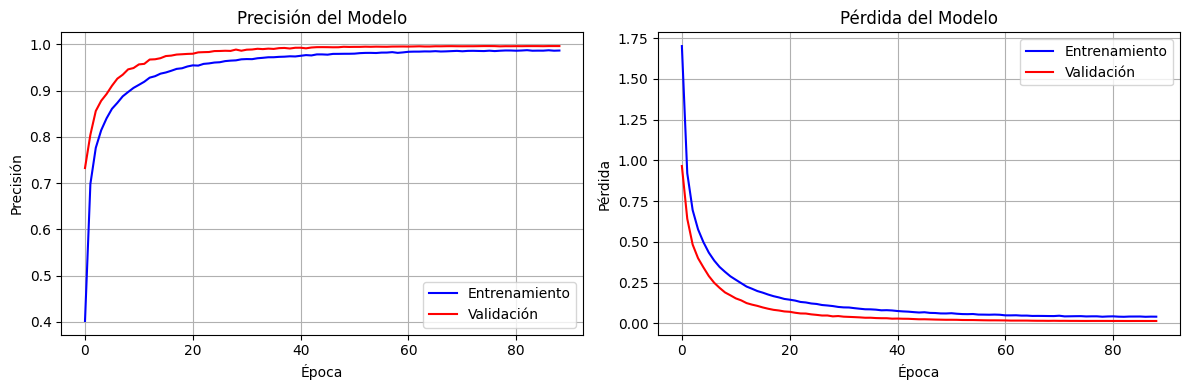

In [49]:
# Gráficas de entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Precisión
ax1.plot(history.history['accuracy'], 'b-', label='Entrenamiento')
ax1.plot(history.history['val_accuracy'], 'r-', label='Validación')
ax1.set_title('Precisión del Modelo')
ax1.set_xlabel('Época')
ax1.set_ylabel('Precisión')
ax1.legend()
ax1.grid(True)

# Pérdida
ax2.plot(history.history['loss'], 'b-', label='Entrenamiento')
ax2.plot(history.history['val_loss'], 'r-', label='Validación')
ax2.set_title('Pérdida del Modelo')
ax2.set_xlabel('Época')
ax2.set_ylabel('Pérdida')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

483/483 [==============================] - 2s 5ms/step

REPORTE DE CLASIFICACIÓN

                     precision    recall  f1-score   support

americano (Clase 0)       0.99      0.99      0.99      1887
   basket (Clase 1)       0.99      1.00      0.99      1712
 beisball (Clase 2)       1.00      1.00      1.00      1500
    boxeo (Clase 3)       1.00      1.00      1.00      1476
 ciclismo (Clase 4)       1.00      1.00      1.00      1576
       f1 (Clase 5)       1.00      0.99      0.99      1006
   futbol (Clase 6)       1.00      1.00      1.00      1511
     golf (Clase 7)       0.99      0.99      0.99      1920
 natacion (Clase 8)       1.00      1.00      1.00      1009
    tenis (Clase 9)       1.00      1.00      1.00      1829

           accuracy                           1.00     15426
          macro avg       1.00      1.00      1.00     15426
       weighted avg       1.00      1.00      1.00     15426


Encontradas 15363 predicciones correctas


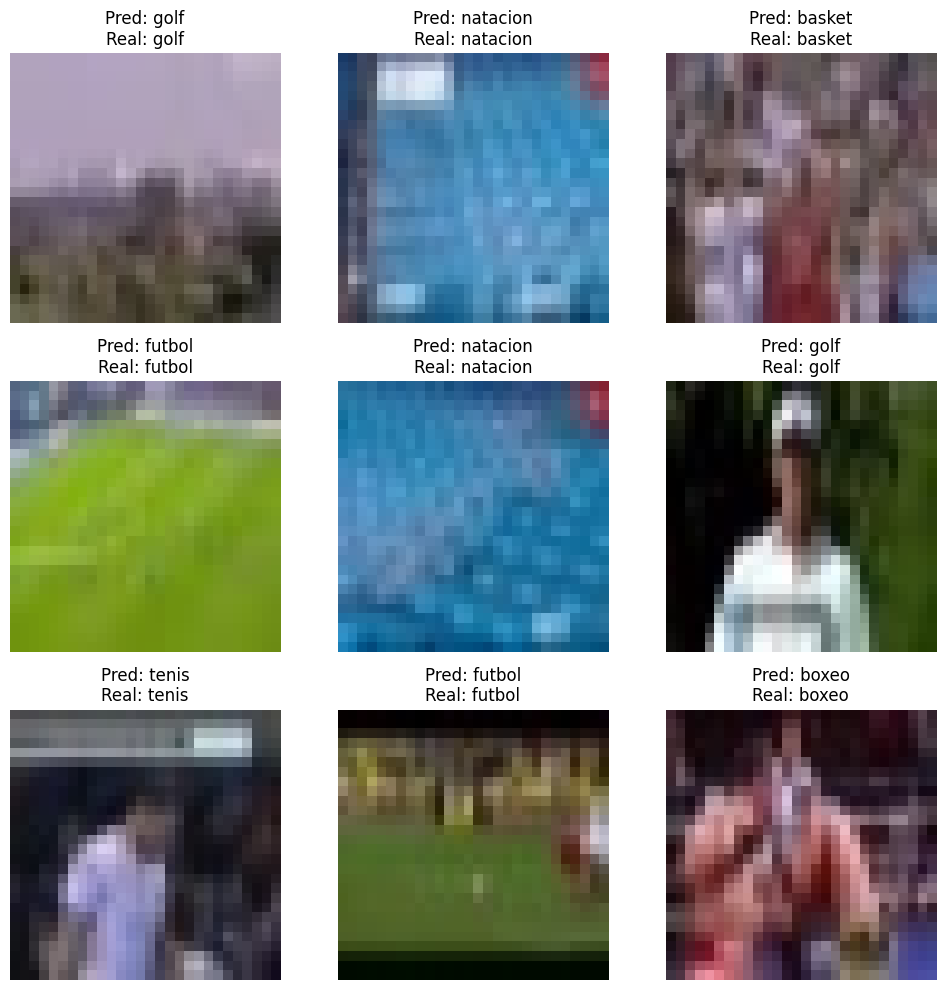


Encontradas 63 predicciones incorrectas


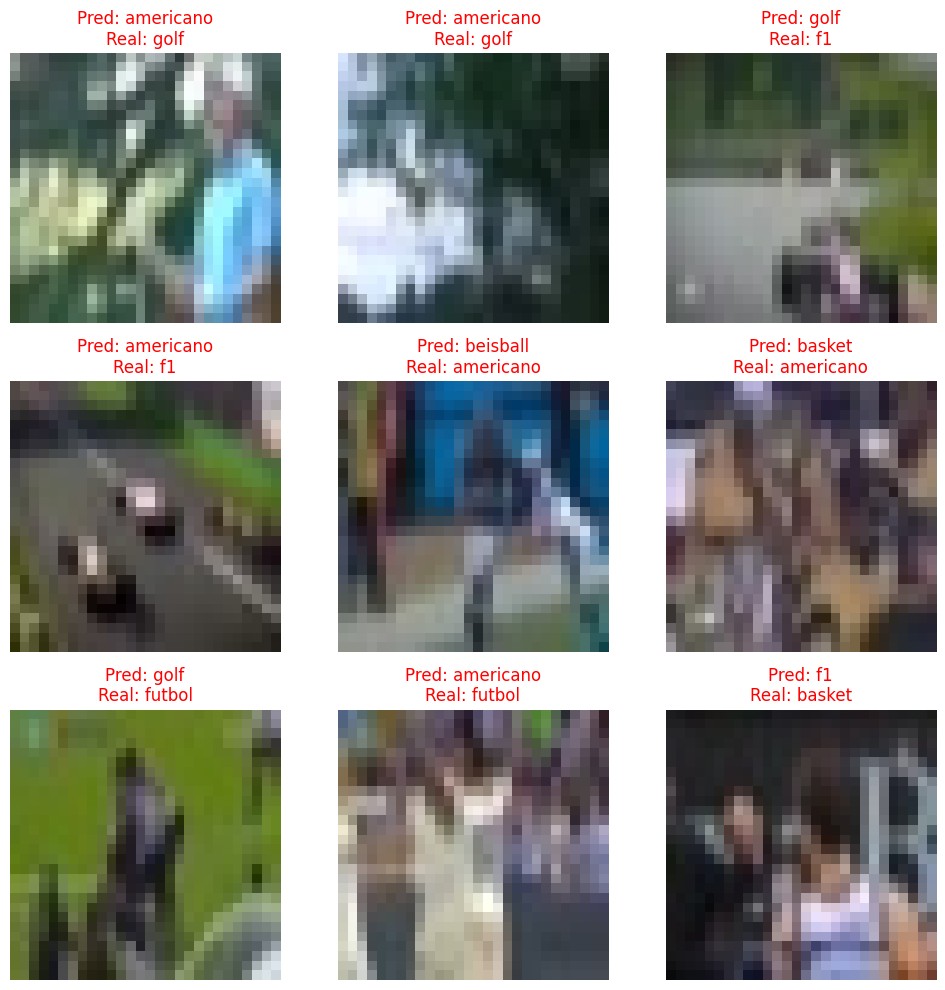

In [50]:
predicted_probs = deportes_model.predict(test_X)
predicted_classes = np.argmax(predicted_probs, axis=1)

print("\n" + "="*50)
print("REPORTE DE CLASIFICACIÓN")
print("="*50 + "\n")

target_names = [f"{deportes[i]} (Clase {i})" for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, 
                           target_names=target_names))

# Visualizar predicciones correctas
correct = np.where(predicted_classes == test_Y)[0]
print(f"\nEncontradas {len(correct)} predicciones correctas")

if len(correct) >= 9:
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, idx in enumerate(correct[:9]):
        ax = axes[i // 3, i % 3]
        ax.imshow(test_X[idx])
        ax.set_title(f"Pred: {deportes[predicted_classes[idx]]}\n"
                    f"Real: {deportes[test_Y[idx]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('correct_predictions.png')
    plt.show()

# Visualizar predicciones incorrectas
incorrect = np.where(predicted_classes != test_Y)[0]
print(f"\nEncontradas {len(incorrect)} predicciones incorrectas")

if len(incorrect) >= 9:
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, idx in enumerate(incorrect[:9]):
        ax = axes[i // 3, i % 3]
        ax.imshow(test_X[idx])
        ax.set_title(f"Pred: {deportes[predicted_classes[idx]]}\n"
                    f"Real: {deportes[test_Y[idx]]}", color='red')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('incorrect_predictions.png')
    plt.show()

In [51]:
def predecir_imagen(filepath, model, deportes):
    """
    Predecir el deporte en una imagen nueva
    
    Args:
        filepath: ruta al archivo de imagen
        model: modelo entrenado
        deportes: lista de nombres de deportes
    
    Returns:
        nombre del deporte predicho y probabilidad
    """
    try:
        # Leer y procesar imagen
        image = plt.imread(filepath)
        image_resized = resize(image, (28, 28), anti_aliasing=True,
                             clip=False, preserve_range=True)
        
        # Asegurar 3 canales
        if len(image_resized.shape) == 2:
            image_resized = np.stack([image_resized]*3, axis=-1)
        
        # Normalizar y agregar dimensión de batch
        image_norm = image_resized.astype('float32') / 255.0
        image_batch = np.expand_dims(image_norm, axis=0)
        
        # Predecir
        prediction = model.predict(image_batch, verbose=0)
        class_idx = np.argmax(prediction[0])
        confidence = prediction[0][class_idx]
        
        return deportes[class_idx], confidence
        
    except Exception as e:
        print(f"Error al procesar {filepath}: {e}")
        return None, 0.0

# Ejemplo de uso
print("\n" + "="*50)
print("EJEMPLO DE PREDICCIÓN")
print("="*50 + "\n")


EJEMPLO DE PREDICCIÓN



In [52]:
# Descomentar para probar con una imagen
deporte, confianza = predecir_imagen('Test.jpg', deportes_model, deportes)
if deporte:
    print(f"Deporte predicho: {deporte}")
    print(f"Confianza: {confianza:.2%}")

print("\n¡Entrenamiento completado exitosamente!")
print(f"Modelo guardado en: {model_path}")

Deporte predicho: americano
Confianza: 79.69%

¡Entrenamiento completado exitosamente!
Modelo guardado en: deportes_model_V5.h5
